$\large{\text{Kiril Klein}}$

In [1209]:
import numpy as np
import scipy.linalg as la
from examplematrices import A1,A2,A3,A4,A5,A6
import chladni_show
import importlib
import matplotlib.pyplot as plt
basis_set = np.load("chladni_basis.npy")
Kmat = np.load("Chladni-Kmat.npy")
A_all = [A1,A2,A3,A4,A5,A6]

# a. Gershgorin's Theorem 

In [1210]:
def gershgorin(A):
    """Computes centers and radii for eigenvalues using Gershgorin's theorem."""
    centers = np.diag(A)
    #subtracting diagonal to sum only off diagonal elements
    radii = abs(A-np.eye(len(A))@np.diag(A))@np.ones(len(A))
    return centers, radii

Kcenters, Kradii = gershgorin(Kmat)
print("Centers: {},\nRadii: {}".format(Kcenters, Kradii))

Centers: [1.29292219e+05 1.03041439e+05 6.49675787e+04 4.36124119e+04
 3.62737515e+04 3.79900994e+04 2.41669711e+04 1.16511587e+04
 1.38650805e+04 5.60054767e+03 1.17303879e+03 1.76077135e+03
 2.88423061e+02 8.68968906e+01 1.38933458e+01],
Radii: [384195.92748975 418490.5202344  431149.23129944 422228.12771613
 431145.33218247 433109.14441566 456169.51676478 461523.33610325
 455913.42519398 468040.86626153 472588.52358391 471872.57235909
 473564.64283112 473698.84883006 473770.18254987]


The radii are relatively large compared to the distance of the centers

# b. Finding Largest Eigenvalues and Eigenvectors

## (1) 

In [1211]:
def rayleigh_qt(A,x):
    """Computes the eigenvalue, given an approximate eigenvector, 
    using the Rayleigh quotient. Returns lambda and rayleigh residual """
    lam = (x.T)@A@x/(x.T@x) #Lambda eigenvalue
    rr = la.norm(A@x-lam*x) #rayleigh residual
    return lam, rr

## (2) 

In [1212]:
def converged(x0,x1, acc=12):
    return la.norm(x0-x1)<10**(-acc)

In [1213]:
def parallel(v1,v2):
    """Check if two vectors are parallel"""
    return abs((v1.T)@v2/(la.norm(v1)*la.norm(v2)))>1-1e-5

In [1215]:
def power_iterate(A, x):
    """Uses the power iteration method to compute eigenvector to the largest eigenvalue.
    Returns eigenvector and number of iterations."""
    k=0
    conv = False
    while( (not conv) and (k<1000)):
        k+=1
        x0 = x
        x = A@x0/la.norm(A@x0)
        conv = converged(x0,x)
    return x, k

Eval_max_A, RR_max_A, K_max_A = [],[],[]
for i in range(len(A_all)):
    M = A_all[i]
    x0 = np.ones(len(M))
    v,k = power_iterate(M,x0)
    lam, rr = rayleigh_qt(M,v)
    Eval_max_A.append(lam), RR_max_A.append(rr), K_max_A.append(k)

| Matrix | Largest Eigenvalue| Rayleigh Residual| Number of Iterations
| --- | --- | --- | --- |
| A1 | 4.0 | 0.0 | 2 |
| A2 | 4.0 | 0.0 | 2 |
| A3 | 12.30 | $1.7\cdot 10^{-12}$ | 28 |
| A4 | 16.12| $8.6 \cdot 10^{-14}$| 12 |
| A5 | 68.64 | $2.9\cdot 10^{-13}$ |  11 |
|A6|  2.0  | $5.4\cdot 10^{-13}$ | 37 |

# Finding largest eigenvalue of Kmat

In [1216]:
v_K,k_K =power_iterate(Kmat, np.ones(len(Kmat)))
lam_K, rr_K = rayleigh_qt(M,v)

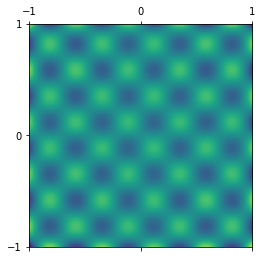

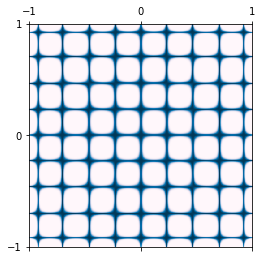

(None, None)

In [1217]:
chladni_show.show_waves(v_K, basis_set),chladni_show.show_nodes(v_K,basis_set)

# c. Rayleigh quotient iteration function 

## (1) 

In the following, approximate solutions to linear systems are computed with the numpy.linalg.lstsq() method because the custom method shows instability for some of the example matrices. This is caused by the division by zero in back substitution occuring when matrices ar nearly singular.

In [1218]:
def shifted_inverse_iterate(A, x, shift):
    """Used to get an approximate Eigenvector for the rayleigh_iterate method."""
    n = len(A)
    k = 0
    while(k<10):
        k+=1
        x = la.lstsq(A-shift*np.eye(n), x)[0]
        x = x/la.norm(x)
    return x

In [1219]:
def rayleigh_iterate(A, x0, shift):
    """Given a vector x0 and shift, finds the closest eigenvalue of matrix A to shift. 
    Returns\n x: Eigenvector\n shift: Eigenvalue\n k: number of iterations\n rr: Rayleigh residual """
    rr, k = 1, 0
    n = len(A)
    x = shifted_inverse_iterate(A,x0,shift)
    while(rr>1e-5 and (k<2000)):
        k+=1
        x = la.lstsq((A-shift*np.eye(n)),x)[0]
        x = x/la.norm(x)
        shift, rr = rayleigh_qt(A,x)
    return x, shift, k, rr

## (2) 

In [1220]:
Eval_A, RR_A, K_A = [],[],[]
for i in range(len(A_all)):
    M = A_all[i]
    lam_max = Eval_max_A[i]
    shift = 2*(np.random.random()-.5)*lam_max
    x0 = np.ones(len(M))
    v,lam,k,rr = rayleigh_iterate(M,x0,shift)
    Eval_A.append(lam), RR_A.append(rr), K_A.append(k)

| Matrix | Eigenvalue example| Rayleigh Residual| Number of Iterations
| --- | --- | --- | --- |
| A1 | 4.0 | $1.3\cdot 10^{-15}$ | 1 |
| A2 | 4.0 | $1.7\cdot 10^{-13}$ | 1 |
| A3 | 12.30 | $7.6\cdot 10^{-6}$ | 2 |
| A4 | -1.1| $6.0 \cdot 10^{-6}$| 3 |
| A5 | 68.64 | $3.1\cdot 10^{-8}$ |  2 |
|A6| 1.5 | $9.0\cdot 10^{-14}$ | 2 |

Compared to power iteration method which provides only the largest eigenvalue, this method requires less iterations and can provide any eigenvalue.

# d. Compute eigenvalues of K 

## (1)

In [1221]:
Centers, Radii = gershgorin(Kmat)
Eigvalues, Eigvectors = la.eig(Kmat)
N = len(Kmat)
x0 = np.ones(N)
Eval, Evec, K, RR = [], [], [], []
for i in range(N):
    v, l, k, rr = rayleigh_iterate(Kmat, x0, Centers[i])
    Eval.append(l), Evec.append(v), K.append(k), RR.append(rr)
Eval = np.array(Eval)
Evec = np.array(Evec).T
sort_ind = np.argsort(Eval)[::-1]
Eval = Eval[sort_ind]
Evec = Evec[:,sort_ind]

There are repeating eigenvalues. Because of the large radius given by Gershgorin's theorem the given center might be closer to a different eigenvalue. Therefore depending on the centers provided by gershgorin not all the eigenvalues can be found with the rayleigh_iterate method.

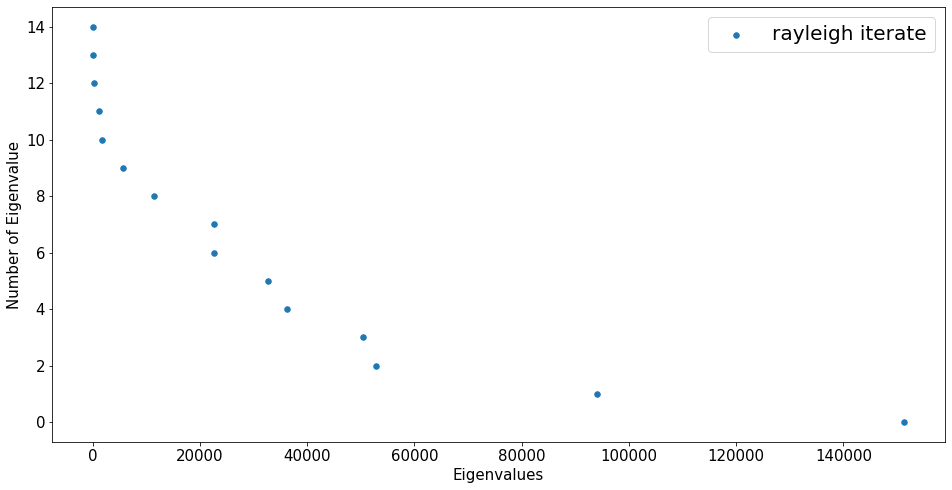

In [1222]:
y = np.arange(N)
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.scatter(Eval,y,s=30, label = 'rayleigh iterate')
plt.legend(fontsize = 20)
plt.ylabel('Number of Eigenvalue', fontsize = 15)
plt.xlabel('Eigenvalues', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize=15)
plt.show()

The following Method checks if all the eigenvalues of Kmat were found.
Therefore it first checks if eigenvalues repeat and if so if there are linearly independent eigenvectors corresponding to this eigenvalues.

In [1223]:
x0 = np.ones(N)
indices = np.arange(N)
for i in range(N):
    k = 0
    while any(np.isclose(Eval[indices != i],Eval[i]))\
        and any([parallel(v,Evec.T[i,:]) for v in (Evec.T[indices != i,:])])\
        and (k<10000): 
            k+=1
            Evec[:,i],Eval[i] = rayleigh_iterate(Kmat, x0, Evec[:,i]+(np.random.random()-.5)*10*k)[:2]
sort_ind = np.argsort(Eval)
Eval = Eval[sort_ind]
Evec = Evec[:,sort_ind]

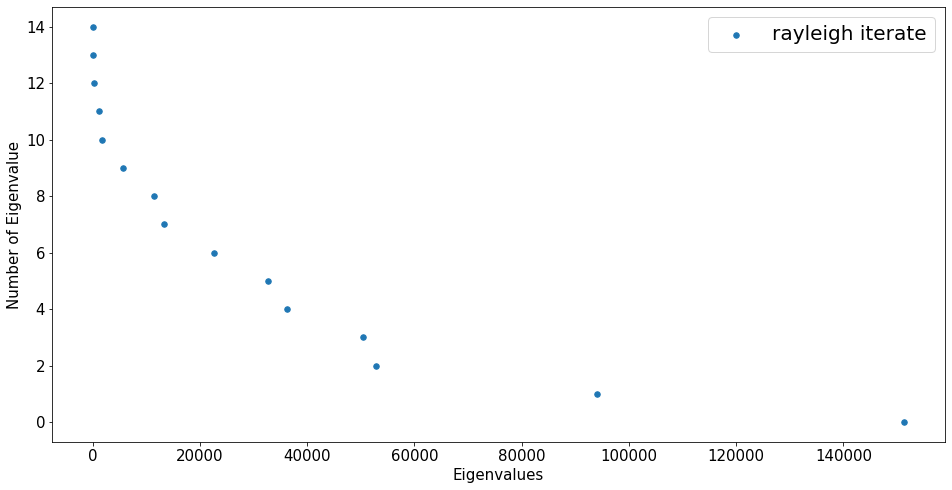

In [1225]:
y = np.arange(N)
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.scatter(Eval[::-1],y,s=30, label = 'rayleigh iterate')
plt.legend(fontsize = 20)
plt.ylabel('Number of Eigenvalue', fontsize = 15)
plt.xlabel('Eigenvalues', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize=15)
plt.show()

## (2) Transformation Matrix

In [1226]:
T = Evec
Lambda = np.eye(N)*Eval
la.norm(Kmat-T@Lambda@la.inv(T)) #The Eigenvalues and Eigenvectors were determined correctly

6.962136845061299e-07

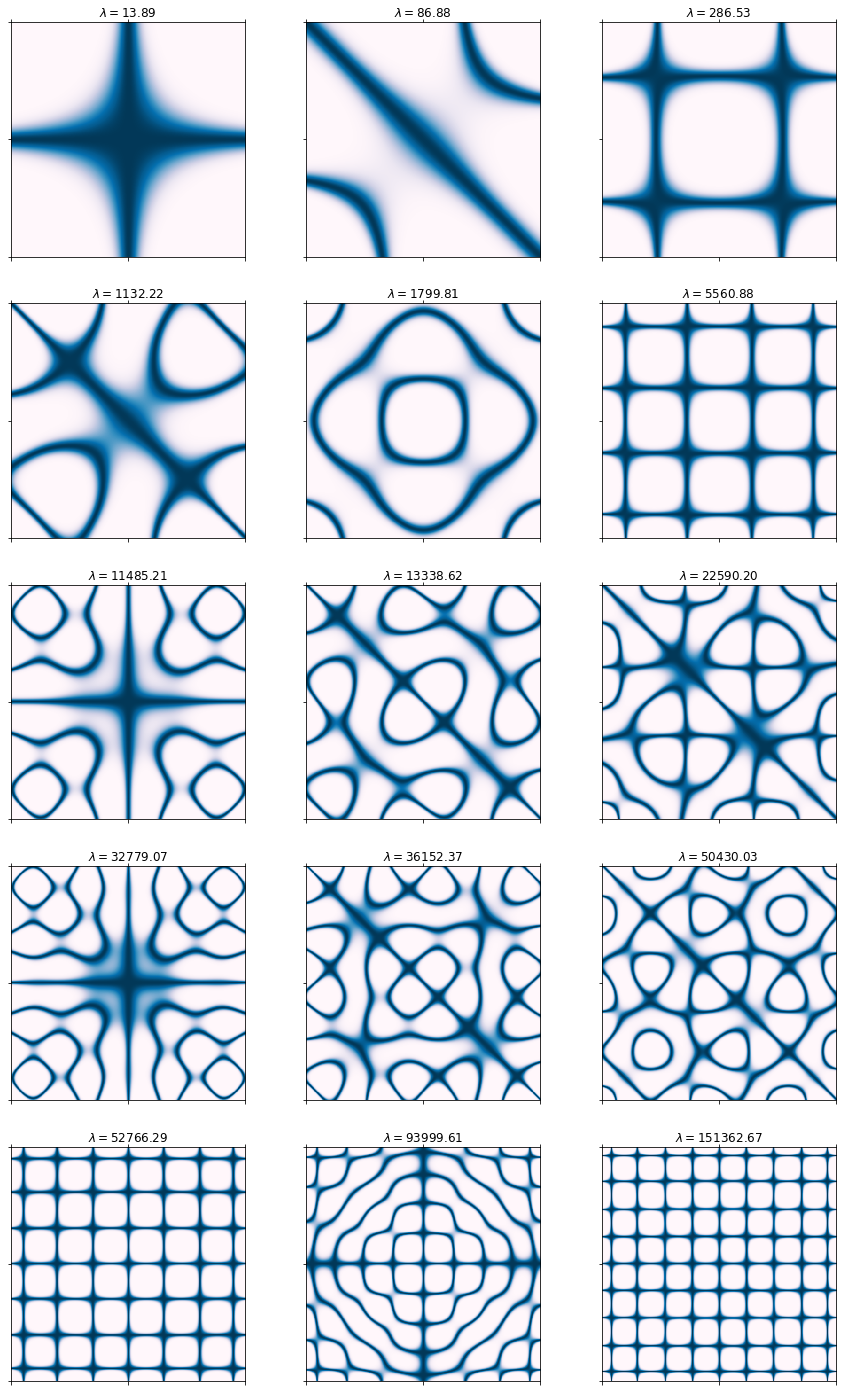

In [1227]:
chladni_show.show_all_wavefunction_nodes(T,Eval,basis_set)